#Baby Names
This notebook is adapted from Wes Mckinley's Python for Data Analysis.

The project analyses given baby names data that is obtained from https://www.ssa.gov/oact/babynames/limits.html

We start by installing the necessary liabilities, importing the libraries and the dataset.

In [ ]:
!pip install pymongo
!wget https://www.ssa.gov/oact/babynames/names.zip
!unzip names.zip -d names

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.0/670.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 19.7 MB/s eta 0:00:00
--2024-05-25 16:26:19--  https://www.ssa.gov/oact/babynames/names.zip
Resolving www.ssa.gov (www.ssa.gov)... 23.48.37.40, 23.48.37.25, 2600:1407:7400:13::173e:2189, ...
Connecting to www.ssa.gov (www.ssa.gov)|23.48.37.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7671699 (7.3M) [application/zip]
Saving to: ‘names.zip’

names.zip           100%[===================>]   7.32M  39.8MB/s    in 0.2s    

2024-05-25 16:26:19 (39.8 MB/s) - ‘names.zip’ saved [7671699/7671699]

Archive:  names.zip
  inflating: names/yob1880.txt       
  inflating: names/yob1881.txt       
  inflating: names/yob1882.txt       
  inflating: names/yob1883.txt       
  inflating: names/yob1884.txt       
  inflating: names/yob1885.txt       
  inflating: names/yob1886.txt       
  inflating: names/yob1887.txt       
  infla

In [ ]:
from time import process_time_ns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pymongo import ASCENDING

In [ ]:
names2007 = pd.read_csv("names/yob2007.txt", names=["names", "sex", "occurrences"])
print(names2007[:5])
print(names2007['sex'].value_counts())
namesex = names2007.groupby("sex").occurrences.sum()
print(namesex)
#you have the file in data columns that gives the baby name given, baby's sex, and number of occurrences of the name

      names sex  occurrences
0     Emily   F        19363
1  Isabella   F        19141
2      Emma   F        18384
3       Ava   F        18053
4   Madison   F        17966
sex
F    20581
M    14394
Name: count, dtype: int64
sex
F    1922257
M    2075000
Name: occurrences, dtype: int64


In [ ]:
#now take all the years into the bubble
years = range(1880,2023)
pieces= []
columns = ["name", "sex", "occurrences"]
for year in years:
    path = "names/yob%d.txt" % year
    frame = pd.read_csv(path, names = columns)

    frame["year"] = year
    pieces.append(frame)

    names= pd.concat(pieces, ignore_index=True)

print(names.head())
print(names.tail())

        name sex  occurrences  year
0       Mary   F         7065  1880
1       Anna   F         2604  1880
2       Emma   F         2003  1880
3  Elizabeth   F         1939  1880
4     Minnie   F         1746  1880
            name sex  occurrences  year
2085532  Zoumana   M            5  2022
2085533   Zuberi   M            5  2022
2085534    Zylon   M            5  2022
2085535   Zymeer   M            5  2022
2085536  Zymeire   M            5  2022


Now that we have obtained all years, we create a graph of births per year.

<Axes: title={'center': 'Total births by sex and year'}, xlabel='year'>

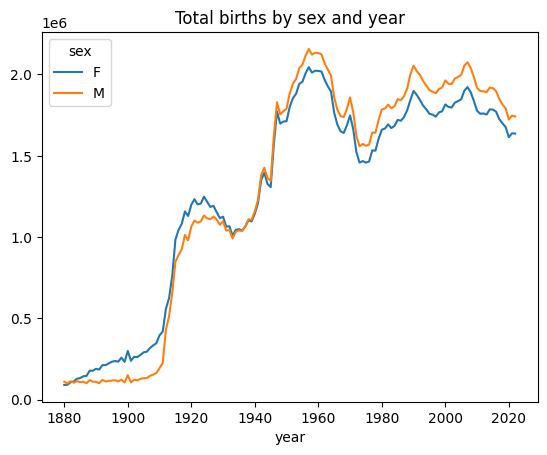

In [ ]:
total_births = names.pivot_table("occurrences", index= "year",  columns="sex",aggfunc=sum)
#you have the last 5 years grouped for births and sex

total_births.plot(title="Total births by sex and year")

We create two functions:

add_prop to obtain the ratio of names compared to the other names grouped by years and sex

get_top1000 to obtain top names

We then use them to obtain information and finally plot what proportion of the births the top 1000 correspond to.


In [ ]:
def add_prop(group):
    occurrences = group.occurrences.astype(float)

    group["prop"] = occurrences / occurrences.sum()
    return group

def get_top1000(group):
    return group.sort_values(by = 'occurrences',ascending=False)[:1000]

In [ ]:
names_prop = names.groupby(["year","sex"]).apply(add_prop).reset_index(drop=True)

print(names_prop.head())

np.allclose(names_prop.groupby(['year','sex']).prop.sum(), 1)

        name sex  occurrences  year      prop
0       Mary   F         7065  1880  0.077642
1       Anna   F         2604  1880  0.028617
2       Emma   F         2003  1880  0.022012
3  Elizabeth   F         1939  1880  0.021309
4     Minnie   F         1746  1880  0.019188


True

260876    0.011547
260877    0.020939
260878    0.029997
260879    0.038963
260880    0.047862
            ...   
261871    0.842385
261872    0.842487
261873    0.842589
261874    0.842691
261875    0.842793
Name: prop, Length: 1000, dtype: float64
25


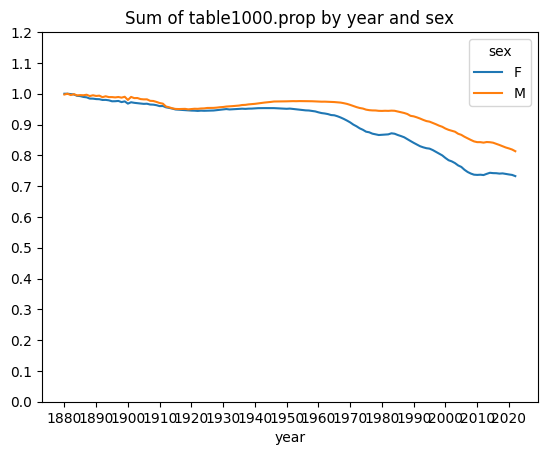

In [ ]:
grouped = names_prop.groupby(["year", "sex"])
top1000 = grouped.apply(get_top1000).reset_index(drop=True)
boys = top1000[top1000.sex== "M"]
girls = top1000[top1000.sex== "F"]

total_births = top1000.pivot_table("occurrences", index="year", columns="name",aggfunc=sum)
subset = total_births[["John","Mary","Harry", "Marilyn"]]

table = top1000.pivot_table("prop", index = "year", columns="sex", aggfunc=sum)
table.plot(title="Sum of table1000.prop by year and sex", yticks = np.linspace(0,1.2,13), xticks = range(1880,2023,10))

df = boys[boys.year ==2010]
prop_cumsum = df.sort_values(by = "prop", ascending=False).prop.cumsum()
print(prop_cumsum)

df = boys[boys.year ==1900]
in1900 = df.sort_values(by = "prop", ascending=False).prop.cumsum()
print(in1900.searchsorted(0.5)+1)

We now focus on the changes in the names,

With get_quantile_count we obtain how many of the top names are needed to reach a certain proportion of the whole births. For this occasion we use 0.5.

The result shows that the diversity in names has increased.

sex    F   M
year        
1880  38  14
1881  38  14
1882  38  15
1883  39  15
1884  39  16


<Axes: title={'center': 'number of popular names in 50%'}, xlabel='year'>

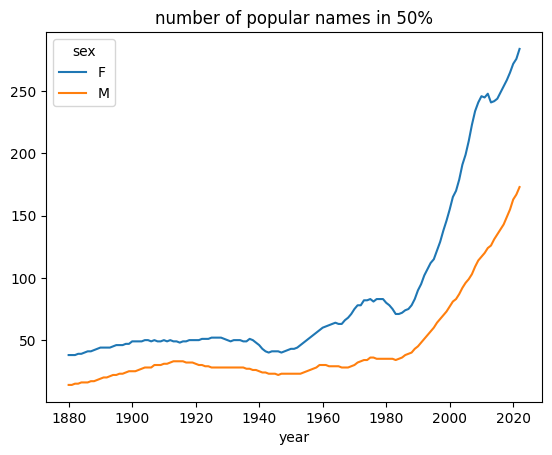

In [ ]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by="prop", ascending=False)
    return group.prop.cumsum().searchsorted(q)+1

diversity = top1000.groupby(["year","sex"]).apply(get_quantile_count)
diversity = diversity.unstack("sex")
print(diversity.head())
diversity.plot(title="number of popular names in 50%")

We then observe the changes in the last letters of the name for three years: 1910, 1960, 2020.

The changes could indicate the small differences how the same name is used e.g July-Juli

A more detailed analysis with a focus on this feature could be helpful in acquiring more information.


sex  year
F    1910     396503.0
     1960    2021888.0
     2020    1614196.0
M    1910     194208.0
     1960    2132033.0
     2020    1723649.0
dtype: float64


<Axes: title={'center': 'Female'}, xlabel='last_letter'>

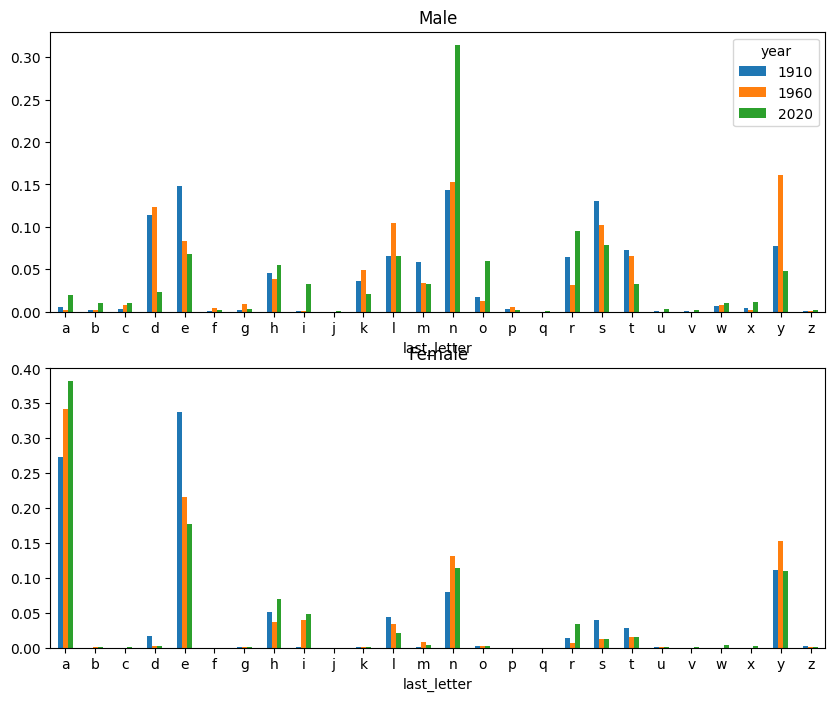

In [ ]:
#shows the last letter change by year
get_last_letter = lambda x:x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = "last_letter"

table = names.pivot_table("occurrences",index=last_letters, columns=["sex","year"], aggfunc=sum)

subtable = table.reindex(columns=[1910,1960,2020], level="year")
print(subtable.sum())

letter_prop = subtable / subtable.sum().astype(float)


fig, axes = plt.subplots(2,1,figsize=(10,8))
letter_prop["M"].plot(kind="bar",rot=0,ax=axes[0], title="Male")
letter_prop["F"].plot(kind="bar",rot=0,ax=axes[1], title="Female", legend=False)
